In [4]:
pip install ucimlrepo

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [21]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bike_sharing = fetch_ucirepo(id=275)

# data (as pandas dataframes)
X = bike_sharing.data.features
y = bike_sharing.data.targets

# metadata
print(bike_sharing.metadata)

# variable information
print(bike_sharing.variables)

{'uci_id': 275, 'name': 'Bike Sharing', 'repository_url': 'https://archive.ics.uci.edu/dataset/275/bike+sharing+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/275/data.csv', 'abstract': 'This dataset contains the hourly and daily count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 17389, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['cnt'], 'index_col': ['instant'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2013, 'last_updated': 'Sun Mar 10 2024', 'dataset_doi': '10.24432/C5W894', 'creators': ['Hadi Fanaee-T'], 'intro_paper': {'ID': 422, 'type': 'NATIVE', 'title': 'Event labeling combining ensemble detectors and background knowledge', 'authors': 'Hadi Fanaee-T, João Gama', 'venue': 'Progress

# **Step 1: Data Inspection & Cleaning**

In [22]:
# Cleaning process
# Load dataset
df = pd.concat([X, y], axis=1)  # Combine features and target into a dataFrame

# Step 1: Inspect the dataset
print("First 5 rows of dataset:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nSummary Statistics:")
print(df.describe())

# Step 2: Check for missing values
print("\nMissing Values in Dataset:")
print(df.isnull().sum())

# Step 3: Feature Engineering - Extract Date Information (mostly verifying if date is in correct format and simplifying for ML processes later)
df['dteday'] = pd.to_datetime(df['dteday'])
df['day_of_week'] = df['dteday'].dt.dayofweek  # 0 = monday, 6 = sunday
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)  # 1 for sat/sun

# Step 4: Convert categorical variables into numerical format
categorical_columns = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']

# Not dropping any columns in case we need them for later

# Step 5: Check for outliers using IQR and remove them for better trend modeling
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]  # Keep only non-outliers

# Step 7: Scale numerical features
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Step 8: Split data into training and testing sets
X = df.drop(columns=['cnt'])  # Features (excluding total count of rentals)
y = df['cnt']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Final Check
print("\nFinal Cleaned Dataset Shape:", df.shape)
print("\nTraining Set Shape:", X_train.shape, y_train.shape)
print("\nTesting Set Shape:", X_test.shape, y_test.shape)


First 5 rows of dataset:
       dteday  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0  2011-01-01       1   0     1   0        0        6           0           1   
1  2011-01-01       1   0     1   1        0        6           0           1   
2  2011-01-01       1   0     1   2        0        6           0           1   
3  2011-01-01       1   0     1   3        0        6           0           1   
4  2011-01-01       1   0     1   4        0        6           0           1   

   temp   atemp   hum  windspeed  cnt  
0  0.24  0.2879  0.81        0.0   16  
1  0.22  0.2727  0.80        0.0   40  
2  0.22  0.2727  0.80        0.0   32  
3  0.24  0.2879  0.75        0.0   13  
4  0.24  0.2879  0.75        0.0    1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 

# **Step 2: Data Visualization**

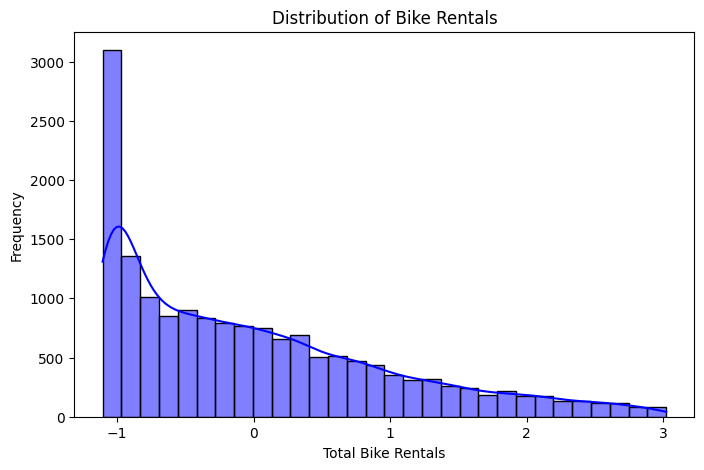

In [23]:
# Visualize distribution of bike rentals on a histogram
plt.figure(figsize=(8, 5))
sns.histplot(df['cnt'], bins=30, kde=True, color='blue')
plt.xlabel('Total Bike Rentals')
plt.ylabel('Frequency')
plt.title('Distribution of Bike Rentals')
plt.show()

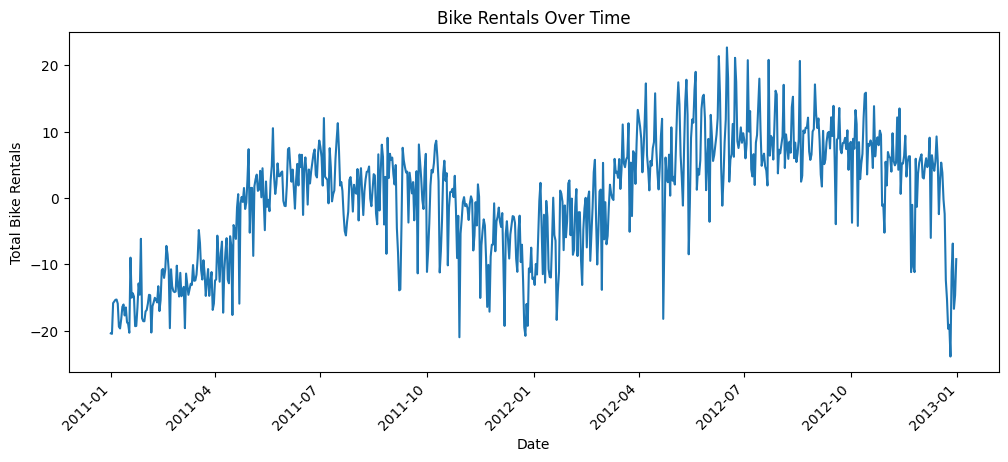

In [24]:
# Visualize bike rentals over time on a line chart
plt.figure(figsize=(12, 5))
df.groupby('dteday')['cnt'].sum().plot()
plt.xlabel('Date')
plt.ylabel('Total Bike Rentals')
plt.title('Bike Rentals Over Time')
plt.xticks(rotation=45)
plt.show()

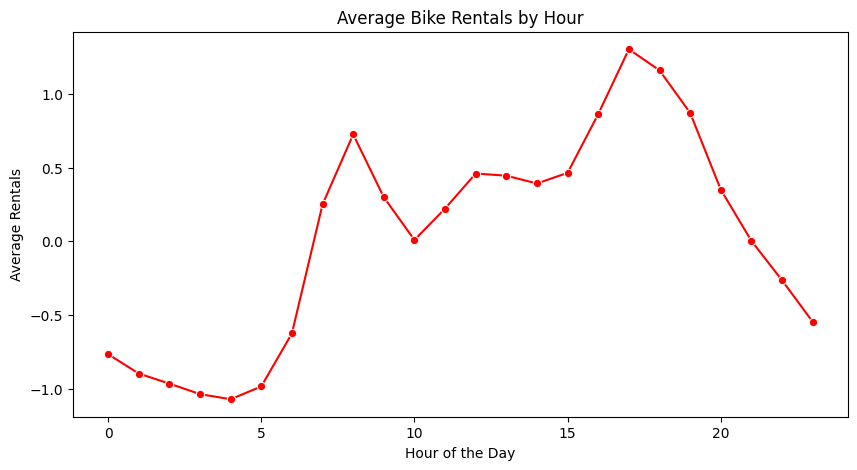

In [27]:
# Visualize average rentals an hour in a line chart
plt.figure(figsize=(10, 5))
sns.lineplot(data=df.groupby('hr')['cnt'].mean(), marker='o', color='red')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Rentals')
plt.title('Average Bike Rentals by Hour')
plt.show()

<ipython-input-31-ad88160d0a8b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['weathersit'], y=df['cnt'], palette='coolwarm')


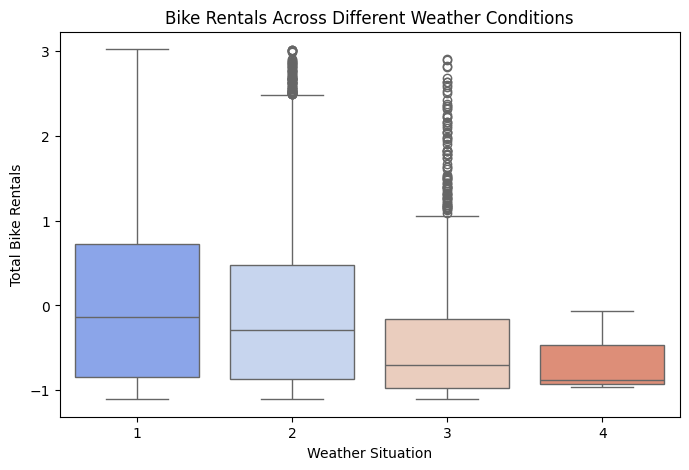

In [31]:
# Impact of the weather on bike rentals
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['weathersit'], y=df['cnt'], palette='coolwarm')
plt.xlabel('Weather Situation')
plt.ylabel('Total Bike Rentals')
plt.title('Bike Rentals Across Different Weather Conditions')
plt.show()

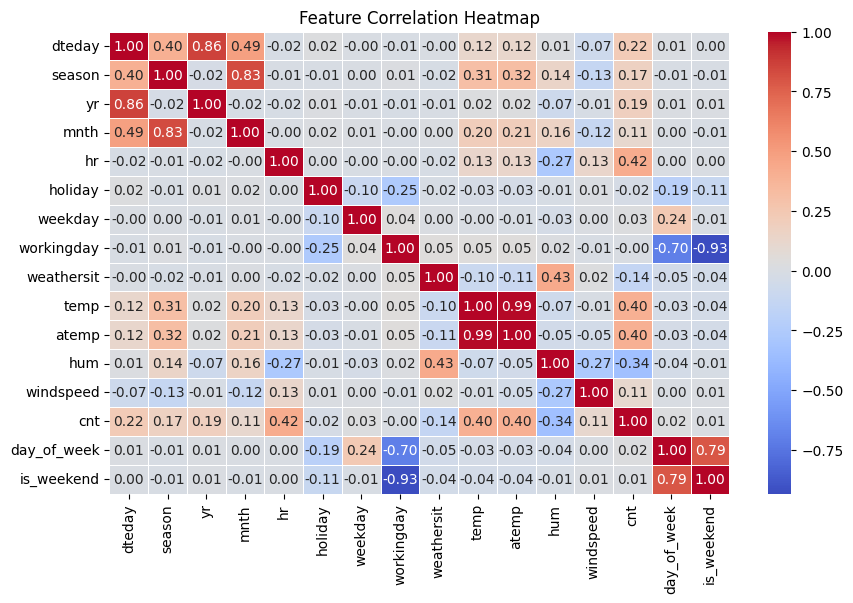

In [30]:
# Heatmap for correlated variables (diregard 1.0 as it's likely it's own variable)
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

Our target variable 'cnt' shows moderate correlations with 'hr', so as the day progresses so does the count of rentals. Also with temp, so as the temp increases rentals tend to increase. However, for humidity 'hum', it shows as humidity increases rentals tend to decrease at -0.34.